In [2]:
from   IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as md
import scipy
from scipy.integrate import solve_ivp
import pandas as pd
import datetime
from statsmodels.tsa.api import VAR
from IPython.display import clear_output

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

fmt     = '\${x:,.2f}'
tick    = mtick.StrMethodFormatter(fmt)
tick2   = mtick.StrMethodFormatter('\${x:,.0f}')
normal  = mtick.StrMethodFormatter('{x:,.0f}')
normal2 = mtick.StrMethodFormatter('{x:,.2f}')

# Functions for the notebook

In [3]:
def rescale_plot(W=5, l=6, w=3, fontsize=10):
    plt.rcParams.update({
            'figure.figsize': (W, W/(l/w)),     # 6:3 aspect ratio
            'font.size' : fontsize,                   # Set font size to 11pt
            'axes.labelsize': fontsize,               # -> axis labels
            'legend.fontsize': fontsize,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble':             # LaTeX preamble
                r"\usepackage{amssymb}\usepackage{lmodern}\usepackage{amsfonts}\usepackage{amsmath}"
                # ... more packages if needed
            
        })

In [4]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def alignYaxes(axes, align_values=None):
    from matplotlib.pyplot import MaxNLocator

    nax=len(axes)
    ticks=[aii.get_yticks() for aii in axes]
    if align_values is None:
        aligns=[ticks[ii][0] for ii in range(nax)]
    else:
        if len(align_values) != nax:
            raise Exception("Length of <axes> doesn't equal that of <align_values>.")
        aligns=align_values

    bounds=[aii.get_ylim() for aii in axes]

    # align at some points
    ticks_align=[ticks[ii]-aligns[ii] for ii in range(nax)]

    # scale the range to 1-100
    ranges=[tii[-1]-tii[0] for tii in ticks]
    lgs=[-np.log10(rii)+2. for rii in ranges]
    igs=[np.floor(ii) for ii in lgs]
    log_ticks=[ticks_align[ii]*(10.**igs[ii]) for ii in range(nax)]

    # put all axes ticks into a single array, then compute new ticks for all
    comb_ticks=np.concatenate(log_ticks)
    comb_ticks.sort()
    locator=MaxNLocator(nbins='auto', steps=[1, 2, 2.5, 3, 4, 5, 8, 10])
    new_ticks=locator.tick_values(comb_ticks[0], comb_ticks[-1])
    new_ticks=[new_ticks/10.**igs[ii] for ii in range(nax)]
    new_ticks=[new_ticks[ii]+aligns[ii] for ii in range(nax)]

    # find the lower bound
    idx_l=0
    for i in range(len(new_ticks[0])):
        if any([new_ticks[jj][i] > bounds[jj][0] for jj in range(nax)]):
            idx_l=i-1
            break

    # find the upper bound
    idx_r=0
    for i in range(len(new_ticks[0])):
        if all([new_ticks[jj][i] > bounds[jj][1] for jj in range(nax)]):
            idx_r=i
            break

    # trim tick lists by bounds
    new_ticks=[tii[idx_l:idx_r+1] for tii in new_ticks]

    # set ticks for each axis
    for axii, tii in zip(axes, new_ticks):
        axii.set_yticks(tii)

    return new_ticks

In [5]:
def getCointRelations_(Prices, dt): # 1min):
    d            = len(Prices.columns)
    Prices       = Prices.reset_index(drop=True)
    model        = VAR(Prices.dropna())
    model_fitted = model.fit(1)
    C            = model_fitted.coefs
    R            = -scipy.linalg.logm(C[0]) / dt
    cointV       = np.linalg.inv(np.linalg.eig(R)[1])
    Sbar         = np.linalg.inv(np.eye(d) - scipy.linalg.expm(-R  * dt) ) @ model_fitted.coefs_exog
    RR           = scipy.sparse.kronsum(R, R).toarray()
    Sigmat       = model_fitted.resid.cov().values 
    Sigma        = np.linalg.inv((np.eye(d*d) - scipy.linalg.expm(- RR * dt))) @ RR @ np.array(np.hstack(Sigmat.T))
    Sigma        = np.reshape(Sigma, (d,d))
    return R, cointV, model_fitted, Sbar[:, 0], Sigma

# Data download

In [6]:
pool1 = 'USDC_WETH_500.csv'
pool2 = 'WBTC_USDC_3000.csv'

pair1 = 'ETHUSDT.csv'
pair2 = 'BTCUSDT.csv'

if False:
    Swapdata1 = pd.read_csv(pool1,infer_datetime_format=True).set_index('swapIndex')#.resample('1')
    Swapdata2 = pd.read_csv(pool2,infer_datetime_format=True).set_index('swapIndex')#.resample('1')

    binancedata1 = pd.read_csv(pair1,infer_datetime_format=True).rename(columns={'Unnamed: 0':'timestamp'})
    binancedata2 = pd.read_csv(pair2,infer_datetime_format=True).rename(columns={'Unnamed: 0':'timestamp'})
    
    # add kappa data
    Swapdata1 = Swapdata1[~Swapdata1.index.duplicated()].sort_index()
    Swapdata1['poolPricePrev'] = Swapdata1['poolPrice'].shift(1)
    Swapdata1['dSwapIndex']    = [0]+list(np.diff(Swapdata1.index))    
    Swapdata1['kappa']         = np.nan
    goodSwapData               = Swapdata1[ ((Swapdata1.amountUSD.abs()>10) & (Swapdata1.dSwapIndex == 1))]
    Swapdata1.loc[goodSwapData.index, 'kappa'] = goodSwapData['amount1'].astype(float) /   (goodSwapData['poolPrice'].astype(float)**-0.5 - goodSwapData['poolPricePrev'].astype(float)**-0.5)

    # add kappa data for 
    Swapdata2 = Swapdata2[~Swapdata2.index.duplicated()].sort_index()
    Swapdata2['poolPrice']     = 1/Swapdata2['poolPrice']
    Swapdata2['poolPricePrev'] = Swapdata2['poolPrice'].shift(1)
    Swapdata2['dSwapIndex']    = [0]+list(np.diff(Swapdata2.index))    
    Swapdata2['kappa']         = np.nan
    goodSwapData               = Swapdata2[ ((Swapdata2.amountUSD.abs()>10) & (Swapdata2.dSwapIndex == 1))]
    Swapdata2.loc[goodSwapData.index, 'kappa'] = goodSwapData['amount0'].astype(float) /   (goodSwapData['poolPrice'].astype(float)**-0.5 - goodSwapData['poolPricePrev'].astype(float)**-0.5)

    Swapdata1['timestamp']    = pd.to_datetime(Swapdata1['timestamp'])
    Swapdata2['timestamp']    = pd.to_datetime(Swapdata2['timestamp'])

    binancedata1['timestamp'] = pd.to_datetime(binancedata1['timestamp'])
    binancedata2['timestamp'] = pd.to_datetime(binancedata2['timestamp'])
    
    from_date = '2022-01-01 00:00'
    to_date   = '2022-07-01 00:00'

    Swapdata1    = Swapdata1[ ((Swapdata1.timestamp<=to_date) & (Swapdata1.timestamp>=from_date))]
    Swapdata2    = Swapdata2[ ((Swapdata2.timestamp<=to_date) & (Swapdata2.timestamp>=from_date))]
    binancedata1 = binancedata1[ ((binancedata1.timestamp<=to_date) & (binancedata1.timestamp>=from_date))]
    binancedata2 = binancedata2[ ((binancedata2.timestamp<=to_date) & (binancedata2.timestamp>=from_date))]
    
    Swapdata1[['timestamp','poolPrice', 'amountUSD',  'amount0', 'amount1', 'kappa']].to_pickle("Swapdata1.pkl")
    Swapdata2[['timestamp','poolPrice', 'amountUSD',  'amount0', 'amount1', 'kappa']].to_pickle("Swapdata2.pkl")
    binancedata1[['timestamp', 'Open', 'Close', 'Volume']].to_pickle("binancedata1.pkl")
    binancedata2[['timestamp', 'Open', 'Close', 'Volume']].to_pickle("binancedata2.pkl")
else:
    Swapdata1 = pd.read_pickle('Swapdata1.pkl')
    Swapdata2 = pd.read_pickle('Swapdata2.pkl')
    binancedata1 = pd.read_pickle('binancedata1.pkl')
    binancedata2 = pd.read_pickle('binancedata2.pkl')

# Data statistics

In [7]:
print('Uniswap volume for ETHUSDC: ', Swapdata1.amountUSD.sum()/1e9)
print('Uniswap volume for BTCUSDC: ', Swapdata2.amountUSD.sum()/1e9)
print('Binance volume for ETHUSDC: ', (binancedata1.Volume*binancedata1.Close).sum()/1e9)
print('Binance volume for BTCUSDC: ', (binancedata2.Volume*binancedata2.Close).sum()/1e9)

Uniswap volume for ETHUSDC:  129.79539863094269
Uniswap volume for BTCUSDC:  5.088557410838686
Binance volume for ETHUSDC:  267.4473617859828
Binance volume for BTCUSDC:  358.3759305863686


In [8]:
print('Uniswap frequency for ETHUSDC: ', int(np.mean(np.diff(Swapdata1.timestamp)/1e9)), "seconds")
print('Uniswap frequency for BTCUSDC: ', int(np.mean(np.diff(Swapdata2.timestamp)/1e9)), "seconds")
print('Binance frequency for ETHUSDC: ', 60/binancedata1.Volume.mean(), "seconds")
print('Binance frequency for BTCUSDC: ', 60/binancedata2.Volume.mean(), "seconds")

Uniswap frequency for ETHUSDC:  13 seconds
Uniswap frequency for BTCUSDC:  380 seconds
Binance frequency for ETHUSDC:  0.12969722813705853 seconds
Binance frequency for BTCUSDC:  1.4895673657857327 seconds


# Co-movement analysis

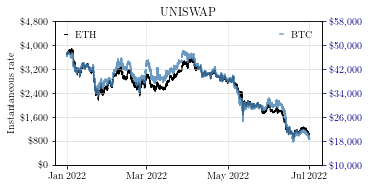

In [9]:
rescale_plot(W=5, l=6, w=3, fontsize=10)

fig, ax1 = plt.subplots(1, 1, constrained_layout=True)
ax2      = ax1.twinx()

ax1.plot(Swapdata1.set_index("timestamp").poolPrice.resample('5min').last(), color='k', lw=1)
ax2.plot(Swapdata2.set_index("timestamp").poolPrice.resample('5min').last(), color='steelblue', lw=1.5, alpha=0.8)

ax1.tick_params('y',colors='k')
ax2.tick_params('y',colors='darkblue')

for ax in (ax1, ax2):
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_formatter(tick2)

ax1.yaxis.set_label_position("left")
ax2.yaxis.set_label_position("right")

ax1.legend(['ETH'], loc='upper left', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)
ax2.legend(['BTC'], loc='upper right', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)

ax1.set_ylabel('Instantaneous rate')
#ax.set_xlabel('Date')
ax1.set_title(r'UNISWAP')
#ax1.grid('both')
ax1.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))
ax1.set_xticks(ax1.get_xticks()[::2])

alignYaxes((ax1,ax2))
plt.savefig('COINT.pdf', bbox_inches='tight')
plt.show()

In [10]:
from_date = '2022-04-01 15:00'
to_date   = '2022-04-01 17:00'

Swapdata2_    = Swapdata2.fillna(method='ffill')[ ((Swapdata2.timestamp<=to_date) & (Swapdata2.timestamp>=from_date))]
binancedata2_ = binancedata2.fillna(method='ffill')[ ((binancedata2.timestamp<=to_date) & (binancedata2.timestamp>=from_date))]

Swapdata1_    = Swapdata1.fillna(method='ffill')[ ((Swapdata1.timestamp<=to_date) & (Swapdata1.timestamp>=from_date))]
binancedata1_ = binancedata1.fillna(method='ffill')[ ((binancedata1.timestamp<=to_date) & (binancedata1.timestamp>=from_date))]

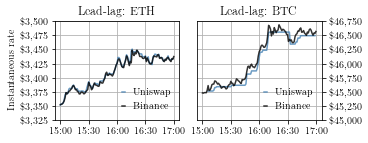

In [11]:
rescale_plot(W=5, l=8, w=3, fontsize=10)

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, sharex=True)

ax2.plot(Swapdata2_.set_index("timestamp").poolPrice.resample('1min').last().fillna(method='ffill'), color='steelblue', lw=1.5, alpha=0.8)
ax2.plot(binancedata2_.set_index("timestamp").Close.resample('1min').last(), color='k', lw=1.5, alpha=0.8)

ax1.plot(Swapdata1_.set_index("timestamp").poolPrice.resample('1min').last().fillna(method='ffill'), color='steelblue', lw=1.5, alpha=0.8)
ax1.plot(binancedata1_.set_index("timestamp").Close.resample('1min').last(), color='k', lw=1.5, alpha=0.8)

for ax in (ax1, ax2):
    ax.grid(axis='both')
    ax.set_axisbelow(True)
    ax.yaxis.set_major_formatter(tick2)
    ax.tick_params('y',colors='k')

ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

ax1.yaxis.set_label_position("left")

ax1.legend(['Uniswap', 'Binance'], loc='lower right', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)
ax2.legend(['Uniswap', 'Binance'], loc='lower right', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)

ax1.set_ylabel('Instantaneous rate')
ax1.set_title(r'Lead-lag: ETH')
ax2.set_title(r'Lead-lag: BTC')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax1.set_xticks(ax1.get_xticks()[::2])

alignYaxes((ax1,ax2))
plt.savefig('LEADLAG.pdf', bbox_inches='tight')
plt.show()

# Cointegration analysis

In [12]:
# np.linalg.matrix_rank(R)
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

# between binance prices
prices1 = binancedata1.set_index('timestamp').Close.resample('5min').last()
prices2 = binancedata2.set_index('timestamp').Close.resample('5min').last()
prices3 = Swapdata1.set_index("timestamp").poolPrice.resample('5min').last().fillna(method='ffill')
prices4 = Swapdata2.set_index("timestamp").poolPrice.resample('5min').last().fillna(method='ffill')

prices1 = prices1[~prices1.index.duplicated(keep='first')]
prices2 = prices2[~prices2.index.duplicated(keep='first')]
prices3 = prices3[~prices3.index.duplicated(keep='first')]
prices4 = prices4[~prices4.index.duplicated(keep='first')]

Prices  = pd.concat((prices1, prices2, prices3, prices4), axis=1).dropna()
timestampIndex = Prices.index
Prices = Prices.reset_index(drop=True)
    
Prices.columns = ['S1', 'S2', 'Z1', 'Z2']

result = coint_johansen(Prices, 0, 1)

print('eigenvectors :')
eigenvectors = result.evec/result.evec[0]
print(eigenvectors)

print(f'Trace static for the null cointegration rank <= 0 : {result.lr1[0]}')
print(f'Critical levels for the null : [90%     95%     99%]')
print(f'Critical values for the null : {result.cvt[0]}')

print(f'Trace static for the null cointegration rank <= 1 : {result.lr1[1]}')
print(f'Critical levels for the null : [90%     95%     99%]')
print(f'Critical values for the null : {result.cvt[1]}')

print(f'Trace static for the null cointegration rank <= 2 : {result.lr1[2]}')
print(f'Critical levels for the null : [90%     95%     99%]')
print(f'Critical values for the null : {result.cvt[2]}')

print(f'Trace static for the null cointegration rank <= 3 : {result.lr1[3]}')
print(f'Critical levels for the null : [90%     95%     99%]')
print(f'Critical values for the null : {result.cvt[3]}')

# print(f'Trace static for the null cointegration rank <= 1 : {result.lr1[2]}')
# print(f'Critical levels for the null : [90%     95%     99%]')
# print(f'Critical values for the null : {result.cvt[2]}')
print(select_coint_rank(Prices, 0, 1, signif=0.05).rank)
select_coint_rank(Prices, 0, 1, signif=0.05).summary()

eigenvectors :
[[ 1.          1.          1.          1.        ]
 [-0.02218232  0.08902653 -0.07240214 -0.14400107]
 [-1.00251126 -1.003903    0.18636557  0.062554  ]
 [ 0.02250571 -0.08826871 -0.03774732  0.31939083]]
Trace static for the null cointegration rank <= 0 : 11195.966337522726
Critical levels for the null : [90%     95%     99%]
Critical values for the null : [44.4929 47.8545 54.6815]
Trace static for the null cointegration rank <= 1 : 4821.519427445466
Critical levels for the null : [90%     95%     99%]
Critical values for the null : [27.0669 29.7961 35.4628]
Trace static for the null cointegration rank <= 2 : 11.445748050608628
Critical levels for the null : [90%     95%     99%]
Critical values for the null : [13.4294 15.4943 19.9349]
Trace static for the null cointegration rank <= 3 : 0.11631698365529894
Critical levels for the null : [90%     95%     99%]
Critical values for the null : [2.7055 3.8415 6.6349]
2


r_0,r_1,test statistic,critical value
0,4,1.120e+04,47.85
1,4,4822.,29.80
2,4,11.45,15.49


In [13]:
prices1, prices2, prices3, prices4 = binancedata1.set_index('timestamp').Close, binancedata2.set_index('timestamp').Close, Swapdata1.set_index("timestamp").poolPrice, Swapdata2.set_index("timestamp").poolPrice
prices1, prices2, prices3, prices4 = prices1[~prices1.index.duplicated(keep='first')], prices2[~prices2.index.duplicated(keep='first')], prices3[~prices3.index.duplicated(keep='first')], prices4[~prices4.index.duplicated(keep='first')]
kappas1, kappas2 = Swapdata1.set_index("timestamp").kappa, Swapdata2.set_index("timestamp").kappa
kappas1, kappas2 = kappas1[~kappas1.index.duplicated(keep='first')], kappas2[~kappas2.index.duplicated(keep='first')]

allPrices  = pd.concat((prices1, prices2, prices3, prices4), axis=1)
allkappas  = pd.concat((kappas1, kappas2), axis=1)

In [14]:
allR, cointV, model_fitted, Sbar, Sigma =  getCointRelations_(allPrices.resample('1min').last().dropna(), dt=int(np.mean(np.diff(allPrices.resample('1min').last().dropna().index)/1e9))/60/60/24 ) # 2 days
print('Sbar = ', Sbar)
print('R = ')
display(pd.DataFrame(allR,columns=Prices.columns, index=Prices.columns).round(2))

Sbar =  [  977.34054256 19501.29273932   973.84558168 19447.88948222]
R = 


,S1,S2,Z1,Z2
S1,11.82,-0.35,-11.74,0.34
S2,47.31,-0.15,-47.09,0.14
Z1,-130.61,3.75,131.43,-3.83
Z2,740.74,-72.79,-742.45,72.87


# In-sample estimation - Out-of-Sample trading for one run

#### In sample estimation

In [199]:
from_date_is = '2022-02-01 00:00'
from_date_os = '2022-02-02 00:00'
to_date_os   = '2022-02-02 12:00'

In [200]:
# in-sample estimation
freq_          = '5min'
Prices         = allPrices.fillna(method='ffill').resample(freq_).last().loc[from_date_is:from_date_os]
timestampIndex = Prices.index
Prices         = Prices.reset_index(drop=True)
Prices.columns = ['S1', 'S2', 'Z1', 'Z2']

In [201]:
R, cointV, model_fitted, Sbar, Sigma =  getCointRelations_(Prices, dt=int(np.mean(np.diff(timestampIndex)/1e9))/60/60/24 ) # 2 days
print('Sbar = ', Sbar)
print('R = ')
display(pd.DataFrame(R,columns=Prices.columns, index=Prices.columns).round(2))

Sbar =  [ 2772.18820526 38621.02489685  2773.92155142 38640.99648673]
R = 


,S1,S2,Z1,Z2
S1,113.06,0.56,-114.26,1.17
S2,420.86,13.38,-523.94,16.44
Z1,-429.20,0.84,434.99,-0.20
Z2,88.93,-106.51,-42.98,101.09


## Out of sample

In [202]:
q0         = np.array([1000, 100]) # initial inventory
eta        = 1/10/24/60 # trading freq
phi        = 1e-6
T          = 12/24
alpha      = np.diag((10, 10))

In [203]:
freq_          = '5min'
Prices         = allPrices.fillna(method='ffill').resample(freq_).last().loc[from_date_os:to_date_os] #.dropna()
timestampIndex = Prices.index
Prices         = Prices.reset_index(drop=True)
Prices.columns = ['S1', 'S2', 'Z1', 'Z2']

Z       = Prices.iloc[:, 2:4]
S       = Prices.iloc[:, :2]

kappas =  allkappas.resample('1min').last().fillna(method='ffill').loc[from_date_os:to_date_os].loc[timestampIndex]

In [204]:
def getspeed(t, qi, SZi, eta, invD, Sbar, A_interp, B_interp):
    return (-0.5/eta) * invD @ ( 2* qi@A_interp(t) + B_interp(t)@ ((SZi-Sbar)/SZi))
def getspeed_AC(t, qi, SZi, eta, invD, A_interp):
    return (-0.5/eta) * invD @ ( 2* qi@A_interp(t))
def solve_ABC(phi, tildeSigma, eta, alpha, Xi, R, invD):
    ts         = np.linspace(0, T, 100000)
    
    print('Solving for A')
    At         = lambda t, s: (phi* tildeSigma - (1/eta) * np.reshape(s, (2,2)).T @ invD @ np.reshape(s, (2,2))).flatten(order='C')
    sol        = solve_ivp(At, [T, 0], -alpha.flatten(order='C'), t_eval=ts[::-1])
    A          = sol.y
    A_         = np.reshape(A, (2,2,np.shape(A)[1]))[:,:,::-1]
    A_interp   = scipy.interpolate.interp1d(ts, A_)
    
    print('Solving for B')
    Bt         = lambda t, s: ( Xi@R.T + np.reshape(s, (2,4))@R.T - (1/eta)*A_interp(t).T@invD@np.reshape(s, (2,4))).flatten(order='C')
    sol        = solve_ivp(Bt, [T, 0], np.zeros(shape=(2,4)).flatten(order='C'), t_eval=ts[::-1])
    B          = sol.y
    B_         = np.reshape(B, (2,4,np.shape(B)[1]))[:,:,::-1]
    B_interp   = scipy.interpolate.interp1d(ts, B_)

#    print('Solving for C')
#    Ct         = lambda t, s: (-Sbar.T@R@Xi.T - Sbar.T@R@B_interp(t).T - (1/eta)*s@invD@A_interp(t)).flatten(order='C')
#    sol        = solve_ivp(Ct, [T, 0], np.zeros(shape=(2)), t_eval=ts[::-1])
#    C          = sol.y
#    C_         = np.reshape(C, (2,np.shape(C)[1]))[:,::-1]
#    C_interp   = scipy.interpolate.interp1d(ts, C_)
    
    return A_interp, B_interp, A_, B_, ts

In [216]:
convexity_t  = Z.values**1.5 / kappas.values
convexity_t[:, 1] = convexity_t[:, 1]/20

D            = np.diag(convexity_t[0])
print('D ='); display(pd.DataFrame(D))

invD       = np.linalg.inv(D)
tildeSigma = Z.diff(1).cov().values

Xi         = np.array([[0,0,1,0],[0,0,0,1]])

R, cointV, model_fitted, Sbar, Sigma =  getCointRelations_(Prices, dt=int(np.mean(np.diff(timestampIndex)/1e9))/60/60/24 ) # 2 days
Sbar  = Prices.mean().values

# solve A, B, C
A_interp, B_interp, A_, B_, ts_ = solve_ABC(phi, tildeSigma, eta, alpha, Xi, allR, invD)

D =


,0,1
0,0.007284,0.000000
1,0.000000,0.292027


Solving for A
Solving for B


### Solving for A and B when t=0

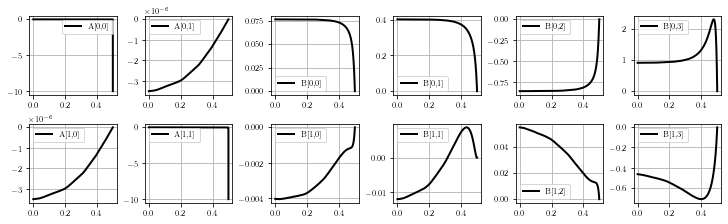

In [217]:
rescale_plot(W=10, l=10, w=3, fontsize=8)
fig, axes=plt.subplots(2, 2+4, constrained_layout=True)
for i in range(2):
    for j in range(2):
        axes[i,j].plot(ts_, A_[i,j,:], color='k', lw=2); axes[i,j].grid('both'); axes[i,j].legend([f'A[{i},{j}]'])
for i in range(2):
    for j in range(4):
        axes[i,2+j].plot(ts_, B_[i,j,:], color='k', lw=2); axes[i,2+j].grid('both'); axes[i,2+j].legend([f'B[{i},{j}]'])
plt.show()

In [218]:
nb_t = len(Z)
dt   = T/nb_t
ts   = np.linspace(0, T, nb_t)

Z_   = Z.values
SZ_  = Prices.values

d                   = len(Z.columns)
q, q_vwap, q_AC     = np.empty((nb_t, d)), np.empty((nb_t, d)), np.empty((nb_t, d))
v, v_vwap, v_AC     = np.empty((nb_t, d)), np.empty((nb_t, d)), np.empty((nb_t, d))
X, X_vwap, X_AC     = np.empty(nb_t), np.empty(nb_t), np.empty(nb_t)
pnl, pnl_vwap, pnl_AC = np.empty(nb_t), np.empty(nb_t), np.empty(nb_t)

SZ0    = SZ_[0]

q[0,:] = q0; q_vwap[0,:] = q0; q_AC[0,:] = q0
v[0,:] = getspeed(0, q0, SZ0, eta, invD, Sbar, A_interp, B_interp)
v_AC[0,:] = getspeed_AC(0, q0, SZ0, eta, invD, A_interp)

X[0]   = 0.; X_vwap[0]   = 0.; X_AC[0]   = 0.
pnl[0] = 0.; pnl_vwap[0] = 0.; pnl_AC[0] = 0.

In [219]:
v_vwap = np.ones((nb_t,2))*(q0/nb_t)/dt

for t in range(nb_t-1):
    # solve for ABC
    #print(t)
    #A_interp, B_interp, A_, B_, _ = solve_ABC(phi, tildeSigma, eta, alpha, Xi, R, np.linalg.inv(np.diag(convexity_t[t,:])))
    v[t,:]   = getspeed(ts[t], q[t,:], SZ_[t], eta, invD, Sbar, A_interp, B_interp)
    q[t+1,:] = q[t,:] - v[t,:] * dt
    X[t+1]   = X[t] + np.dot(v[t,:],Z_[t,:])*dt - np.dot(v[t,:],dt*np.diag(convexity_t[t,:])@v[t,:])*dt
    pnl[t+1] = X[t+1] + np.dot(Z_[t+1,:],q[t+1,:]) - np.dot(Z_[0,:],q[0,:])
    
    v_AC[t,:]   = getspeed_AC(ts[t], q_AC[t,:], SZ_[t], eta, invD, A_interp)
    q_AC[t+1,:] = q_AC[t,:] - v_AC[t,:] * dt
    X_AC[t+1]   = X_AC[t] + np.dot(v_AC[t,:],Z_[t,:])*dt - np.dot(v_AC[t,:],dt*np.diag(convexity_t[t,:])@v_AC[t,:])*dt
    pnl_AC[t+1] = X_AC[t+1] + np.dot(Z_[t+1,:],q_AC[t+1,:]) - np.dot(Z_[0,:],q_AC[0,:])
    
    q_vwap[t+1,:] = q_vwap[t,:] - v_vwap[t,:] * dt
    X_vwap[t+1]   = X_vwap[t]   + np.dot(v_vwap[t,:],Z_[t,:])*dt - np.dot(v_vwap[t,:],dt*np.diag(convexity_t[t,:])@v_vwap[t,:])*dt
    pnl_vwap[t+1] = X_vwap[t+1] + np.dot(Z_[t+1,:],q_vwap[t+1,:]) - np.dot(Z_[0,:],q_vwap[0,:])

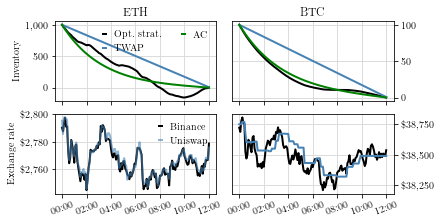

In [231]:
rescale_plot(W=6, l=6, w=3, fontsize=10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True, sharex=True)

ax1.plot(timestampIndex, q[:,0], color='k', lw=2)
ax1.plot(timestampIndex, q_vwap[:,0], color='steelblue', lw=2)
ax1.plot(timestampIndex, q_AC[:,0], color='green', lw=2)

ax2.plot(timestampIndex, q[:,1], color='k', lw=2)
ax2.plot(timestampIndex, q_vwap[:,1], color='steelblue', lw=2)
ax2.plot(timestampIndex, q_AC[:,1], color='green', lw=2)

ax3.plot(timestampIndex, Prices['S1'], color='k', lw=2)
ax3.plot(timestampIndex, Prices['Z1'], color='steelblue', lw=2, alpha=0.6)
ax4.plot(timestampIndex, Prices['S2'], color='k', lw=2)
ax4.plot(timestampIndex, Prices['Z2'], color='steelblue', lw=2)

ax1.legend(['Opt. strat.', 'TWAP', 'AC'], loc='upper right', fancybox=True, framealpha=0., handlelength=0.3, ncol=2)
#ax2.legend(['Opt. strat.', 'TWAP'], loc='upper left', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)
ax3.legend(['Binance', 'Uniswap'], loc='upper right', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)
#ax4.legend(['Binance', 'Uniswap'], loc='upper left', fancybox=True, framealpha=0., handlelength=0.3, ncol=1)

for ax in (ax1, ax2, ax3, ax4):
    ax.grid('both')
    #ax.yaxis.label.set_color('grey')
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    
for ax in (ax1, ax3):
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    
for ax in (ax2, ax4):
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
for ax in (ax1, ax2): ax.yaxis.set_major_formatter(normal)
for ax in (ax3, ax4): ax.yaxis.set_major_formatter(tick2)
#alignYaxes((ax1,ax2))

ax1.set_ylabel('Inventory')
ax3.set_ylabel('Exchange rate')
ax1.set_title(r'ETH'); ax2.set_title(r'BTC')

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax3.tick_params(axis='x', rotation=20)
ax4.tick_params(axis='x', rotation=20)

plt.savefig('Inventory.pdf', bbox_inches='tight')
plt.show()

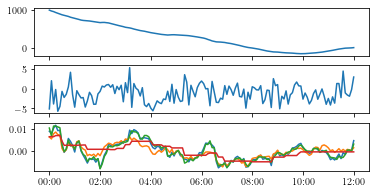

In [215]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(timestampIndex, q[:, 0])
ax[1].plot(timestampIndex, Prices.iloc[:,0]-Prices.iloc[:,2])
ax[2].plot(timestampIndex, (Prices.values-Sbar)/Sbar)
ax[2].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

In [27]:
pnl[-1]

-73852.19014189113

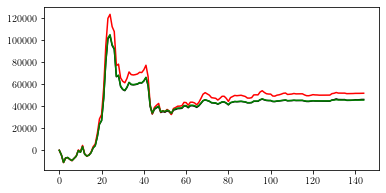

In [44]:
plt.plot(pnl, 'k')
plt.plot(pnl_vwap, "red")
plt.plot(pnl_AC, "g")

# Rolling trading

In [232]:
q0_         = np.array([0, 0]) # initial inventory
eta        = 1/24/60 # trading freq
phi        = 1e-6
T          = 12/24
alpha      = np.diag((10, 10))

isT        = 1 #12/24
osT        = 12/24
hour_shift = 12        

freq_      = '5min'

In [233]:
rescale_plot(W=8, l=6, w=3, fontsize=10)

np.random.seed(26) #18, 19
pnl_dict = {}
from_date_is = '2022-01-01 00:00'
from_date_os = '2022-01-02 00:00'
to_date_os   = '2022-01-02 12:00'

while to_date_os != '2022-06-30 12:00':
    try:
        q0 = np.random.choice((-1, 1))* q0_
        #####################################################################
        # in-sample estimation
        #####################################################################
        Prices         = allPrices.resample(freq_).last().loc[from_date_is:from_date_os].dropna()
        timestampIndex = Prices.index
        Prices         =  Prices.reset_index(drop=True)
        Prices.columns = ['S1', 'S2', 'Z1', 'Z2']
        R, cointV, model_fitted, Sbar, Sigma =  getCointRelations_(Prices, dt=int(np.mean(np.diff(timestampIndex)/1e9))/60/60/24 ) # 2 days
        
        ######################################################
        # Out of sample trading
        ######################################################
        Prices         = allPrices.fillna(method='ffill').resample(freq_).last().loc[from_date_os:to_date_os] #.dropna()
        timestampIndex = Prices.index
        Prices         = Prices.reset_index(drop=True)
        Prices.columns = ['S1', 'S2', 'Z1', 'Z2']
        Z, S       = Prices.iloc[:, 2:4], Prices.iloc[:, :2]
        
        kappas =  allkappas.resample('1min').last().fillna(method='ffill').loc[from_date_os:to_date_os].loc[timestampIndex]
        convexity_t  = Z.values**1.5 / kappas.values
        convexity_t[:, 1] = convexity_t[:, 1]/50
        D            = np.diag(convexity_t[0])
        invD         = np.linalg.inv(D)
        tildeSigma   = Z.diff(1).cov().values
        Xi           = np.array([[0,0,1,0],[0,0,0,1]])
        #R, cointV, model_fitted, Sbar, Sigma =  getCointRelations_(Prices, dt=int(np.mean(np.diff(timestampIndex)/1e9))/60/60/24 ) # 2 days
        Sbar         = Prices.mean().values
        
        # solve A, B, C
        A_interp, B_interp, A_, B_, ts_ = solve_ABC(phi, tildeSigma, eta, alpha, Xi, allR, invD)
        
        nb_t = len(Z)
        dt   = T/nb_t
        ts   = np.linspace(0, T, nb_t)

        Z_   = Z.values
        SZ_  = Prices.values

        d                   = len(Z.columns)
        q, q_vwap, q_AC     = np.empty((nb_t, d)), np.empty((nb_t, d)), np.empty((nb_t, d))
        v, v_vwap, v_AC     = np.empty((nb_t, d)), np.empty((nb_t, d)), np.empty((nb_t, d))
        X, X_vwap, X_AC     = np.empty(nb_t), np.empty(nb_t), np.empty(nb_t)
        pnl, pnl_vwap, pnl_AC = np.empty(nb_t), np.empty(nb_t), np.empty(nb_t)

        SZ0    = SZ_[0]

        q[0,:] = q0; q_vwap[0,:] = q0; q_AC[0,:] = q0
        v[0,:] = getspeed(0, q0, SZ0, eta, invD, Sbar, A_interp, B_interp)
        v_AC[0,:] = getspeed_AC(0, q0, SZ0, eta, invD, A_interp)

        X[0]   = 0.; X_vwap[0]   = 0.; X_AC[0]   = 0.
        pnl[0] = 0.; pnl_vwap[0] = 0.; pnl_AC[0] = 0.
        
        v_vwap = np.ones((nb_t,2))*(q0/nb_t)/dt

        for t in range(nb_t-1):
            # solve for ABC
            #print(t)
            #A_interp, B_interp, A_, B_, _ = solve_ABC(phi, tildeSigma, eta, alpha, Xi, R, np.linalg.inv(np.diag(convexity_t[t,:])))
            v[t,:]   = getspeed(ts[t], q[t,:], SZ_[t], eta, invD, Sbar, A_interp, B_interp)
            q[t+1,:] = q[t,:] - v[t,:] * dt
            X[t+1]   = X[t] + np.dot(v[t,:],Z_[t,:])*dt - np.dot(v[t,:],dt*np.diag(convexity_t[t,:])@v[t,:])*dt
            pnl[t+1] = X[t+1] + np.dot(Z_[t+1,:],q[t+1,:]) - np.dot(Z_[0,:],q[0,:])

            v_AC[t,:]   = getspeed_AC(ts[t], q_AC[t,:], SZ_[t], eta, invD, A_interp)
            q_AC[t+1,:] = q_AC[t,:] - v_AC[t,:] * dt
            X_AC[t+1]   = X_AC[t] + np.dot(v_AC[t,:],Z_[t,:])*dt - np.dot(v_AC[t,:],dt*np.diag(convexity_t[t,:])@v_AC[t,:])*dt
            pnl_AC[t+1] = X_AC[t+1] + np.dot(Z_[t+1,:],q_AC[t+1,:]) - np.dot(Z_[0,:],q_AC[0,:])
            
            q_vwap[t+1,:] = q_vwap[t,:] - v_vwap[t,:] * dt
            X_vwap[t+1]   = X_vwap[t]   + np.dot(v_vwap[t,:],Z_[t,:])*dt - np.dot(v_vwap[t,:],dt*np.diag(convexity_t[t,:])@v_vwap[t,:])*dt
            pnl_vwap[t+1] = X_vwap[t+1] + np.dot(Z_[t+1,:],q_vwap[t+1,:]) - np.dot(Z_[0,:],q_vwap[0,:])
        
        ######################################################
        # Store results
        ######################################################
        clear_output()
        print(from_date_is + ' ----> ' + to_date_os)
        print('\n', 'D=', np.round(D, 4))
        
        pnl_dict[from_date_is] = {'optimal':pnl[-1], 'twap':pnl_vwap[-1], 'AC':pnl_AC[-1]}
        
        print('\n','Pnls=')
        display(pd.DataFrame.from_dict({strat:[ pnl_dict[k][strat] for k in pnl_dict.keys()] for strat in ('optimal', 'twap', 'AC')}).mean())
        if False:
            fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
            ax.plot(q[:,0], color='k');    ax.plot(q_vwap[:,0], color='b');    ax.plot(q_AC[:,0], color='g')
            ax2.plot(q[:,1], color='k');   ax2.plot(q_vwap[:,1], color='b');    ax2.plot(q_AC[:,1], color='g')
            ax3.plot(Z_[:,0], color='k');  ax4.plot(Z_[:,1], color='k')
            ax3.plot(SZ_[:,0], color='b'); ax4.plot(SZ_[:,1], color='b')
            ax5.plot(pnl, color='k');      ax5.plot(pnl_vwap, color='b');  ax6.plot(pnl_AC, color='g'); ax5.sharey(ax6)
            ax7.plot(kappas1.values, color='b');  ax8.plot(kappas2.values, color='b')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print('Error: ', str(e))
        
    from_date_is = datetime.datetime.strftime(datetime.datetime.strptime(from_date_is, '%Y-%m-%d %H:%M')+datetime.timedelta(hours = hour_shift), '%Y-%m-%d %H:%M')
    from_date_os = datetime.datetime.strftime(datetime.datetime.strptime(from_date_os, '%Y-%m-%d %H:%M')+datetime.timedelta(hours = hour_shift), '%Y-%m-%d %H:%M')
    to_date_os   = datetime.datetime.strftime(datetime.datetime.strptime(to_date_os, '%Y-%m-%d %H:%M')+datetime.timedelta(hours = hour_shift),   '%Y-%m-%d %H:%M')

2022-06-28 12:00 ----> 2022-06-30 00:00

 D= [[0.0028 0.    ]
 [0.     0.0489]]

 Pnls=


optimal    2658.233453
twap          0.000000
AC            0.000000
dtype: float64

18:<br>
optimal    1776.794226 <br>
twap      -2302.497128 <br>
AC         -894.088222

24: 4452.968130 	1193.978548 	1782.266342


In [234]:
pnlDF = pd.DataFrame.from_dict({strat:[ pnl_dict[k][strat] for k in pnl_dict.keys()] for strat in ('optimal', 'twap', 'AC')})
pnlDF.index = pnl_dict.keys()
pnlDF.sort_values(by='optimal').describe()

,optimal,twap,AC
count,357.000000,357.0,357.0
mean,2658.233453,0.0,0.0
std,5819.730415,0.0,0.0
min,-35901.865469,0.0,0.0
25%,1011.250931,0.0,0.0
50%,2080.162867,0.0,0.0
75%,4665.576560,0.0,0.0
max,28497.484177,0.0,0.0
